__Вводные данные:__

C целью определить лучший баннер в мобильном приложении, тестовой группе пользователей была предложена версия с другим цветовым решением с одинаковой возможность покупки платного функционала. A/B-тест был проведен в период с 08.05.2019 по 09.05.2019. 

__Задача:__

Необходимо оценить какой из вариантов баннера является более предпочтительным для пользователей из региона US.

__Данные:__

__`Таблица Users`__:
- `UserID` – идентификационный номер пользователей;
- `Country` – регион продажи;
- `Group` – тип исследуемой группы.

__`Таблица Revenue`__:

- `UserID` – идентификационный номер пользователей;
- `Date` – дата просмотра пользователем баннера;
- `Revenue` – выручка от приобретения пользователем платного функционала, BYN
---

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import statsmodels.api as sm
from datetime import datetime

In [33]:
users = pd.read_excel('result.xlsx', sheet_name=1, usecols='A:C', nrows=40000, dtype={'UserID': np.int_}, keep_default_na=False)
revenue = pd.read_excel('result.xlsx', sheet_name=1, usecols='F:H', nrows=378525, names=['UserID', 'Date', 'Revenue'], dtype={'UserID': np.int_, 'Date': datetime, 'Revenue': np.float_})

In [137]:
# выборка данных согласно задаче
users_control = users[(users.Country == 'US') & (users.Group == 'Control')]
users_target = users[(users.Country == 'US') & (users.Group == 'Target')]
revenue_ab = revenue[(revenue.Date == datetime(2019, 5, 8)) | (revenue.Date == datetime(2019, 5, 9))]

In [138]:
# сегментирование относительно выручки
revenue_control = (pd.merge(users_control[['UserID']], revenue_ab[['UserID', 'Revenue']], on='UserID')).groupby('UserID').sum()
revenue_target = (pd.merge(users_target[['UserID']], revenue_ab[['UserID', 'Revenue']], on='UserID')).groupby('UserID').sum()

In [139]:
# расчёт основных параметров для построения графика плотности распределения случайной величины (в данном случае она характеризует выручку)
mean_cntrl = np.mean(revenue_control['Revenue'])
sd_cntrl = np.std(revenue_control['Revenue']) 
mean_trgt = np.mean(revenue_target['Revenue'])
sd_trgt = np.std(revenue_target['Revenue'])

norm_cntrl = sts.norm(loc=mean_cntrl, scale=sd_cntrl)
norm_trgt = sts.norm(loc=mean_trgt, scale=sd_trgt)

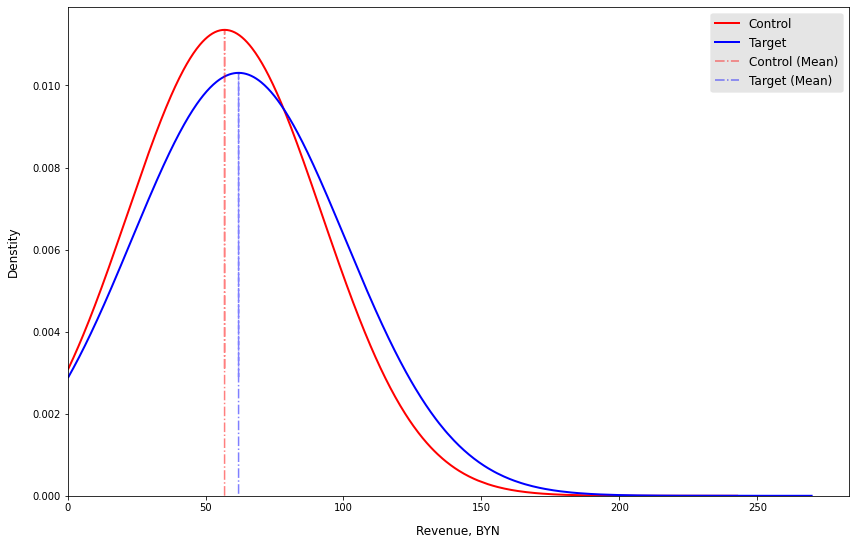

In [176]:
# график плотностей распределений выручки
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot()

x1 = revenue_control['Revenue'].sort_values().values
pdf1 = norm_cntrl.pdf(x1)
x2 = revenue_target['Revenue'].sort_values().values
pdf2 = norm_trgt.pdf(x2)
data_line_cntrl = ax.plot(x1, pdf1, 'r', label='Control', linewidth=2)
data_line_trgt = ax.plot(x2, pdf2, 'b', label='Target', linewidth=2)

x_mean_cntrl = [mean_cntrl] * len(pdf1)
x_mean_trgt = [mean_trgt] * len(pdf2)
mean_line_cntrl = ax.plot(x_mean_cntrl, pdf1, 'r-.', label='Control (Mean)', alpha=0.5)
mean_line_trgt = ax.plot(x_mean_trgt, pdf2, 'b-.', label='Target (Mean)', alpha=0.5)

plt.xlabel('Revenue, BYN', labelpad=12, fontsize=12)
plt.ylabel('Denstity', labelpad=12, fontsize=12)

plt.legend(fontsize=12, facecolor='k', framealpha=0.1)

ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)

plt.show()

Проверим на нормальность распределения выручки.
Сперва наглядно, с помощью графиков __QQ-plot__, а затем количественно, с помощью __теста Шапиро-Уилка__.

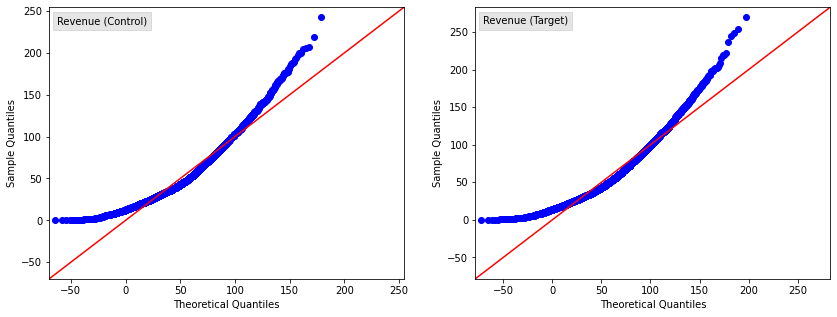

In [170]:
# графики QQ-plot
f, ax = plt.subplots(1, 2)

f.set_size_inches(14, 5)

sm.qqplot(revenue_control.Revenue, loc=mean_cntrl, scale=sd_cntrl, line="45", ax=ax[0])
txt = ax[0].text(ax[0].get_xlim()[0] * 0.9, ax[0].get_ylim()[1] * 0.92, 'Revenue (Control)')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

sm.qqplot(revenue_target.Revenue, loc=mean_trgt, scale=sd_trgt, line="45", ax=ax[1])
txt = ax[1].text(ax[1].get_xlim()[0] * 0.9, ax[1].get_ylim()[1] * 0.92, 'Revenue (Target)')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

plt.show()

Графики показывают значительное различие между теоретическими и экспериментальными кривыми. __Максимальные__ и __минимальные значения слишком высоки для нормального распределения__.
Подтвердим это количественно.

Определим __нулевую H0__ и __альтернативную H1 гипотезы__:
- `H0`: распределение является нормальным;
- `H1`: распределение не является нормальным.

In [173]:
_, p_shapiro_cntrl = sts.shapiro(np.array(revenue_control.Revenue))
_, p_shapiro_trgt = sts.shapiro(np.array(revenue_target.Revenue))
print(p_shapiro_cntrl, p_shapiro_trgt)

1.8758508797614679e-37 1.2466947461841708e-38


$p-value$ и контрольной, и тестовой групп __не позволяет принять нулевую гипотезу__.

Из всего вышесказанного можно сделать вывод, что __распределения не являются нормальными__.
Поэтому для определения статистической значимости результата А/B-тестирования воспользуемся непараметрическим тестом: __тестом Манна-Уитни__.

Снова определим __нулевую H0__ и __альтернативную H1 гипотезы__:
- `H0`: старый баннер предпочтительнее;
- `H1`: новый баннер предпочтительнее.

In [174]:
sts.mannwhitneyu(np.array(revenue_control.Revenue), np.array(revenue_target.Revenue))

MannwhitneyuResult(statistic=7267858.5, pvalue=3.783840725216628e-08)

$p-value$ слишком мал, чтобы подтвердить нулевую гипотезу. Поэтому можно сделать заключение в пользу альтернативной: __новый баннер всё же более предпочтительнее__.